In [1]:
import numpy as np
import datetime
import pandas as pd
import os
from matplotlib import pyplot as plt

import matplotlib
from matplotlib import colors as mpl_colors
import seaborn as sns

from flywireconnectome import figures as fcf

In [2]:
HOME = os.path.expanduser("~")
analysis_dir = f"{HOME}/Dropbox/AL Murthy Lab/FlyWire Data/630_reciprocal_space/"
data_dir = f"{HOME}/Dropbox/AL Murthy Lab/FlyWire Data/projectome_783/data"
a_data_dir = f"{HOME}/Dropbox/AL Murthy Lab/FlyWire Data/projectome_783/analysis_data"

In [3]:
csv_readout = pd.read_csv((analysis_dir + "v630-all-reciprocal-pairs-s1.csv"),dtype={"n1":np.int64,"n2":np.int64})
root_ids_1 = csv_readout["n1"]
root_ids_2 = csv_readout["n2"]
nt_1 = csv_readout["n1_nt"]
nt_2 = csv_readout["n2_nt"]

In [4]:
v630_v783_df = pd.read_feather(f"{data_dir}/proofread_neuron_mapping_630_to_783.feather")

In [5]:
v630_v783_df[root_ids_1[0] == v630_v783_df["root_id_630"]]["root_id_783"]

31931    720575940616702465
Name: root_id_783, dtype: uint64

In [6]:
#load synapse table for 783
synapse_df = pd.read_feather(f"{a_data_dir}/syn_proof_analysis_filtered_consolidated_T5syn_ntavg_783.feather")

In [7]:
len(root_ids_1)

180799

In [8]:
syn_to_np_df = pd.read_feather(f"{data_dir}/syn_np_map_783.feather")

In [9]:
syn_to_np_df

,syn_id,neuropil
0,61513306,PLP_L
1,61513307,PLP_L
2,61513308,PLP_L
3,61513309,PLP_L
4,61513310,PLP_L
...,...,...
244358221,61513301,PLP_L
244358222,61513302,PLP_L
244358223,61513303,PLP_L
244358224,61513304,PLP_L


In [10]:
reciprocal_df = csv_readout
#matches for n1
reciprocal_df = reciprocal_df.rename(columns={"n1": "root_id_630"})
reciprocal_df = pd.merge(reciprocal_df,v630_v783_df[["root_id_630","root_id_783"]],how="left",on="root_id_630")
reciprocal_df = reciprocal_df.rename(columns={"root_id_630": "root_id_630_n1","root_id_783": "root_id_783_n1"})

#matches for n2
reciprocal_df = reciprocal_df.rename(columns={"n2": "root_id_630"})
reciprocal_df = pd.merge(reciprocal_df,v630_v783_df[["root_id_630","root_id_783"]],how="left",on="root_id_630")
reciprocal_df = reciprocal_df.rename(columns={"root_id_630": "root_id_630_n2","root_id_783": "root_id_783_n2"})

In [11]:
len(reciprocal_df)

180799

In [227]:
#printing just one
# look up by opening reciprocal csv: csv index -2
idx = 1228
neuron_id_1 = reciprocal_df.iloc[idx].root_id_783_n1
neuron_id_2 = reciprocal_df.iloc[idx].root_id_783_n2

#(synapse_df["syn_count"] >= 5) & 

synapses_dir1_df = synapse_df[
           (synapse_df["pre_pt_root_id"] == neuron_id_1) & (synapse_df["post_pt_root_id"] == neuron_id_2)]
print(synapses_dir1_df)

synapses_dir2_df = synapse_df[
           (synapse_df["pre_pt_root_id"] == neuron_id_2) & (synapse_df["post_pt_root_id"] == neuron_id_1)]
print(synapses_dir2_df)

#synapses_dir1_df["neuropil"][synapses_dir1_df["syn_count"].idxmax(axis=0)]

            pre_pt_root_id     post_pt_root_id neuropil  syn_count  gaba_avg  \
724147  720575940615886534  720575940626671626    SLP_R          2  0.799861   
724148  720575940615886534  720575940626671626     LH_R          7  0.891575   

         ach_avg  glut_avg   oct_avg   ser_avg    da_avg  
724147  0.010156  0.188920  0.000030  0.000123  0.000911  
724148  0.022051  0.081004  0.000214  0.001191  0.003964  
             pre_pt_root_id     post_pt_root_id neuropil  syn_count  gaba_avg  \
2181073  720575940626671626  720575940615886534    SLP_R          5  0.003951   
2181074  720575940626671626  720575940615886534     LH_R          2  0.000804   

          ach_avg  glut_avg   oct_avg   ser_avg    da_avg  
2181073  0.927306  0.002932  0.025007  0.000639  0.040164  
2181074  0.971046  0.000069  0.023433  0.000006  0.004643  


In [144]:
len(reciprocal_df)

180799

In [145]:
%%time
# we can try winner-take-all first: takes 33 minutes
loop_range = range(0,len(reciprocal_df)) 
np_1to2 = []
np_2to1 = []

for idx in loop_range:
    neuron_id_1 = reciprocal_df.iloc[idx].root_id_783_n1
    neuron_id_2 = reciprocal_df.iloc[idx].root_id_783_n2

#(synapse_df["syn_count"] >= 5) & 

    synapses_dir1_df = synapse_df[
           (synapse_df["pre_pt_root_id"] == neuron_id_1) & (synapse_df["post_pt_root_id"] == neuron_id_2)]
    if synapses_dir1_df.empty:
        np_1to2.append("None")
    else:
        np_1to2.append(synapses_dir1_df["neuropil"][synapses_dir1_df["syn_count"].idxmax(axis=0)])

    synapses_dir2_df = synapse_df[
           (synapse_df["pre_pt_root_id"] == neuron_id_2) & (synapse_df["post_pt_root_id"] == neuron_id_1)]
    if synapses_dir2_df.empty:
        np_2to1.append("None")
    else:
        np_2to1.append(synapses_dir2_df["neuropil"][synapses_dir2_df["syn_count"].idxmax(axis=0)])

CPU times: user 17min 26s, sys: 1.48 s, total: 17min 27s
Wall time: 33min 4s


In [146]:
reciprocal_df["np_1to2"] = np_1to2
reciprocal_df["np_2to1"] = np_2to1

In [127]:
reciprocal_df

,root_id_630_n1,root_id_630_n2,n1_nt,n2_nt,root_id_783_n1,root_id_783_n2,np_1to2,np_2to1
0,720575940616702465,720575940633062335,glut,ach,720575940616702465,720575940633062335,LAL_R,LAL_R
1,720575940610584184,720575940616841361,gaba,ach,720575940610584184,720575940616841361,AVLP_L,AVLP_L
2,720575940627218882,720575940627263375,gaba,ach,720575940627218882,720575940627263375,AMMC_L,PVLP_L
3,720575940630085583,720575940639278781,ach,gaba,720575940630085583,720575940639278781,LAL_R,LAL_R
4,720575940622527100,720575940625513859,gaba,ach,720575940642624475,720575940625513859,ME_L,ME_L
...,...,...,...,...,...,...,...,...
180794,720575940619717717,720575940628432456,ach,gaba,720575940619717717,720575940628432456,ME_R,ME_R
180795,720575940627375375,720575940646833028,ach,gaba,720575940627375375,720575940622084161,ME_R,ME_R
180796,720575940631667682,720575940634138775,ach,gaba,720575940631667682,720575940647436835,AVLP_R,AVLP_R
180797,720575940607447241,720575940621688948,ach,ach,720575940607447241,720575940621688948,ME_L,ME_L


In [151]:
reciprocal_df.to_csv(f"{analysis_dir}/reciprocal_np_df.csv",index=False)

In [126]:
# load saved dataframe
reciprocal_df = pd.read_csv((analysis_dir + "reciprocal_np_df.csv"),dtype={"root_id_630_n1":np.int64,"root_id_630_n2":np.int64,"root_id_783_n1":np.int64,"root_id_783_n2":np.int64})

In [4]:
# list with different root IDs
reciprocal_df[reciprocal_df["np_1to2"] != reciprocal_df["np_2to1"]]

,root_id_630_n1,root_id_630_n2,n1_nt,n2_nt,root_id_783_n1,root_id_783_n2,np_1to2,np_2to1
2,720575940627218882,720575940627263375,gaba,ach,720575940627218882,720575940627263375,AMMC_L,PVLP_L
21,720575940630769145,720575940644582964,gaba,gaba,720575940630769145,720575940644582964,SPS_L,ICL_L
27,720575940616390261,720575940621397503,gaba,ach,720575940616390261,720575940615258163,IPS_L,WED_R
35,720575940635211768,720575940637341668,gaba,ach,720575940635211768,720575940637341668,GOR_L,SAD
66,720575940616633925,720575940620866036,ach,gaba,720575940616633925,720575940620866036,PVLP_L,SAD
...,...,...,...,...,...,...,...,...
180778,720575940615751124,720575940629679660,glut,glut,720575940615751124,720575940624705514,SPS_R,ICL_R
180780,720575940613065130,720575940633233087,glut,ach,720575940613065130,720575940633233087,LO_R,PVLP_R
180781,720575940618447936,720575940634763871,ach,glut,720575940618002747,720575940622364598,SPS_R,VES_R
180783,720575940618135973,720575940630131062,ach,gaba,720575940618135973,720575940615205427,AVLP_R,PVLP_R


In [8]:
# load color information
cam_color_df = pd.read_feather(f"{data_dir}/colors_seatable.feather")

cam_color_map = {}
for col in cam_color_df.columns[1:5]:
    cam_color_map.update(cam_color_df[~cam_color_df[col].isna()][[col, "hex"]].set_index(col).to_dict()["hex"])
    
for name, color_hex in cam_color_map.items():
    cam_color_map[name] = matplotlib.colors.to_rgb(f'{color_hex}')

for name, color_hex in list(cam_color_map.items()):
    if name.endswith("_L") or name.endswith("_R"):
        cam_color_map[name[:-2]] = cam_color_map[name]
    
cam_color_map["GA_L"] = cam_color_map["GA"]
cam_color_map["GA_R"] = cam_color_map["GA"]

cam_color_map["intrinsic"] = cam_color_map["central"]
cam_color_map["efferent"] = cam_color_map["descending"]
cam_color_map["afferent"] = cam_color_map["ascending"]
cam_color_map["non-vis. sensory"] = cam_color_map["sensory"]

cam_color_map[None] = [.5, .5, .5]
cam_color_map["None"] = [.5, .5, .5]
cam_color_map["unknown_sensory"] = [.5, .5, .5]

In [9]:
# load neuropil information
np_name_map = dict(zip(*np.array(pd.read_csv(f"{data_dir}/neuropil_order.csv")[["Neuropil", "Neuropil Display name"]]).T))
np_name_map["LA_L"] = "LA(L)"
np_name_map["LA_R"] = "LA(R)"
np_name_map["OCG"] = "OCG"

In [10]:
left_neuropils = ["LA_L", "ME_L", "AME_L", "LO_L", "LOP_L",
                  "PLP_L", "PVLP_L", "AOTU_L",
                  'AL_L', 'LH_L', 'MB_CA_L', 'MB_PED_L',
                  'MB_VL_L', 'MB_ML_L', 'BU_L', 'GA_L', 'LAL_L', 'SLP_L', 'SIP_L',
                  'SMP_L', 'CRE_L', 'SCL_L', 'ICL_L', 'IB_L', 'ATL_L', 'VES_L',
                  'EPA_L', 'GOR_L', 'SPS_L', 'IPS_L', 'AVLP_L',
                  "WED_L", "CAN_L", "FLA_L", "AMMC_L"]
central_neuropils = ['FB', 'EB', 'PB', 'NO','OCG', 'PRW', 'SAD', 'GNG']
right_neuropils = [n.replace("_L", "_R") for n in left_neuropils] # this is where the flip happened

# neuropils = np.array(left_neuropils + central_neuropils + right_neuropils[5:] + right_neuropils[:5])
neuropils = np.array(left_neuropils + central_neuropils + right_neuropils)
np_display_names = np.array([np_name_map[n] for n in neuropils])

In [11]:
left_m = np.isin(neuropils, [s for s in neuropils if s.endswith("_L")])
right_m = np.isin(neuropils, [s for s in neuropils if s.endswith("_R")])
central_m = np.isin(neuropils, [s for s in neuropils if not s.endswith("_L") and not s.endswith("_R")])

neuropils = np.concatenate([neuropils[left_m], neuropils[central_m], neuropils[right_m]])
np_display_names = np.concatenate([np_display_names[left_m], np_display_names[central_m], np_display_names[right_m]])


In [18]:
len(reciprocal_df[(reciprocal_df["np_1to2"] == "EB") & (reciprocal_df["np_2to1"] == "FB")])

1

In [13]:
%%time
# count number of connections between neuropil pairs 

n = len(neuropils)
reciprocal_raw_matrix = np.zeros((n, n))

for i in range(n):
    np_i = neuropils[i]
    for j in range(n):
        np_j = neuropils[j]
        reciprocal_raw_matrix[i][j] = len(reciprocal_df[(reciprocal_df["np_1to2"] == np_i) & (reciprocal_df["np_2to1"] == np_j)])


        
#(will have to sum opposites)
        
print(reciprocal_raw_matrix)

[[2.000e+00 1.100e+01 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [9.000e+00 2.775e+04 1.000e+01 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 4.000e+00 5.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 2.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 1.050e+02 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.090e+02]]
CPU times: user 1min 39s, sys: 131 ms, total: 1min 40s
Wall time: 1min 40s


In [25]:
# upper triangle projectome
reciprocal_raw_matrix.max()

39078.0

In [14]:
def nt_colormap(nt):
    if nt == "all":
        color = [0, 0, 0]
    else:
        color = cam_color_map[nt]

    cdict = {
        "red": [[0, 1, 1.], [1, color[0], 1.]],
        "green": [[0, 1, 1.], [1, color[1], 1.]],
        "blue": [[0, 1, 1.], [1, color[2], 1.]],
    }
    
    return mpl_colors.LinearSegmentedColormap('c',segmentdata=cdict)
    

In [15]:
def nt_reciprocal_heatmap(intrinsic_df, cmap, out_path=None,
                  vmin=1, vmax=1e3, label_fontsize=4, log_scale=True, 
                 colorbar_label="# reciprocal pairs"):
    
    if log_scale:
        color_norm = mpl_colors.LogNorm(vmin=vmin, vmax=vmax)
    else:
        color_norm = mpl_colors.Normalize(vmin=vmin, vmax=vmax)
        
    fig = plt.figure(figsize=(5, 5), dpi=300, facecolor="white")
    ax = plt.axes()


    # Intrinsic
    sns.heatmap(np.array(intrinsic_df), cmap=cmap, cbar=False, square=True,
                norm=color_norm, ax=ax,
                cbar_kws={"shrink": .25, "label": "# reciprocal neuron pairs"})

    ax.tick_params(length=0, width=1.5, labelsize=label_fontsize)
    
    ax.set_xticks(np.arange(len(neuropils)) + .5, [n.split("(")[0] for n in np_display_names], rotation=90)
    for i, n in enumerate(neuropils):
        ax.get_xticklabels()[i].set_color(cam_color_map[n])
                   
    ax.set_yticks(np.arange(len(neuropils)) + .5, [n.split("(")[0] for n in np_display_names], rotation=0)
    for i, n in enumerate(neuropils):
        ax.get_yticklabels()[i].set_color(cam_color_map[n])
                   
    ax.vlines(np.cumsum([np.sum(left_m), np.sum(central_m)]), 0, len(intrinsic_df), color="k", lw=.5)
    ax.hlines(np.cumsum([np.sum(left_m), np.sum(central_m)]), 0, len(intrinsic_df), color="k", lw=.5)
    
    plt.tight_layout()
    if out_path is not None:
        fcf.savefig(out_path)
    plt.show() 
            
    fig, ax = plt.subplots(1, figsize=(3, 2), subplot_kw=dict(xticks=[], yticks=[]), dpi=300)
    colors = cmap(np.arange(cmap.N))
    
    for ax in fig.axes:
        ax.spines["bottom"].set_linewidth(0)
        ax.spines["left"].set_linewidth(0)
        ax.spines["right"].set_linewidth(0)
        ax.spines["top"].set_linewidth(0)

    
    ax.imshow([colors], extent=[0, 10, 0, 1])
    if log_scale:
        ax.set_xticks([0, 10], [f"$10^{int(np.log10(vmin))}$", f"$10^{int(np.log10(vmax))}$"], fontsize=18)
    else:
        ax.set_xticks([0, 10], [vmin, vmax], fontsize=18)
    ax.set_xlabel(colorbar_label, fontsize=18)
    
    plt.tight_layout()
    if out_path is not None:
        fcf.savefig(out_path.replace(".png", "_colorbar.png"))
    plt.show()

[[2.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [2.000e+01 2.775e+04 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 1.400e+01 5.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 2.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 1.050e+02 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.090e+02]]


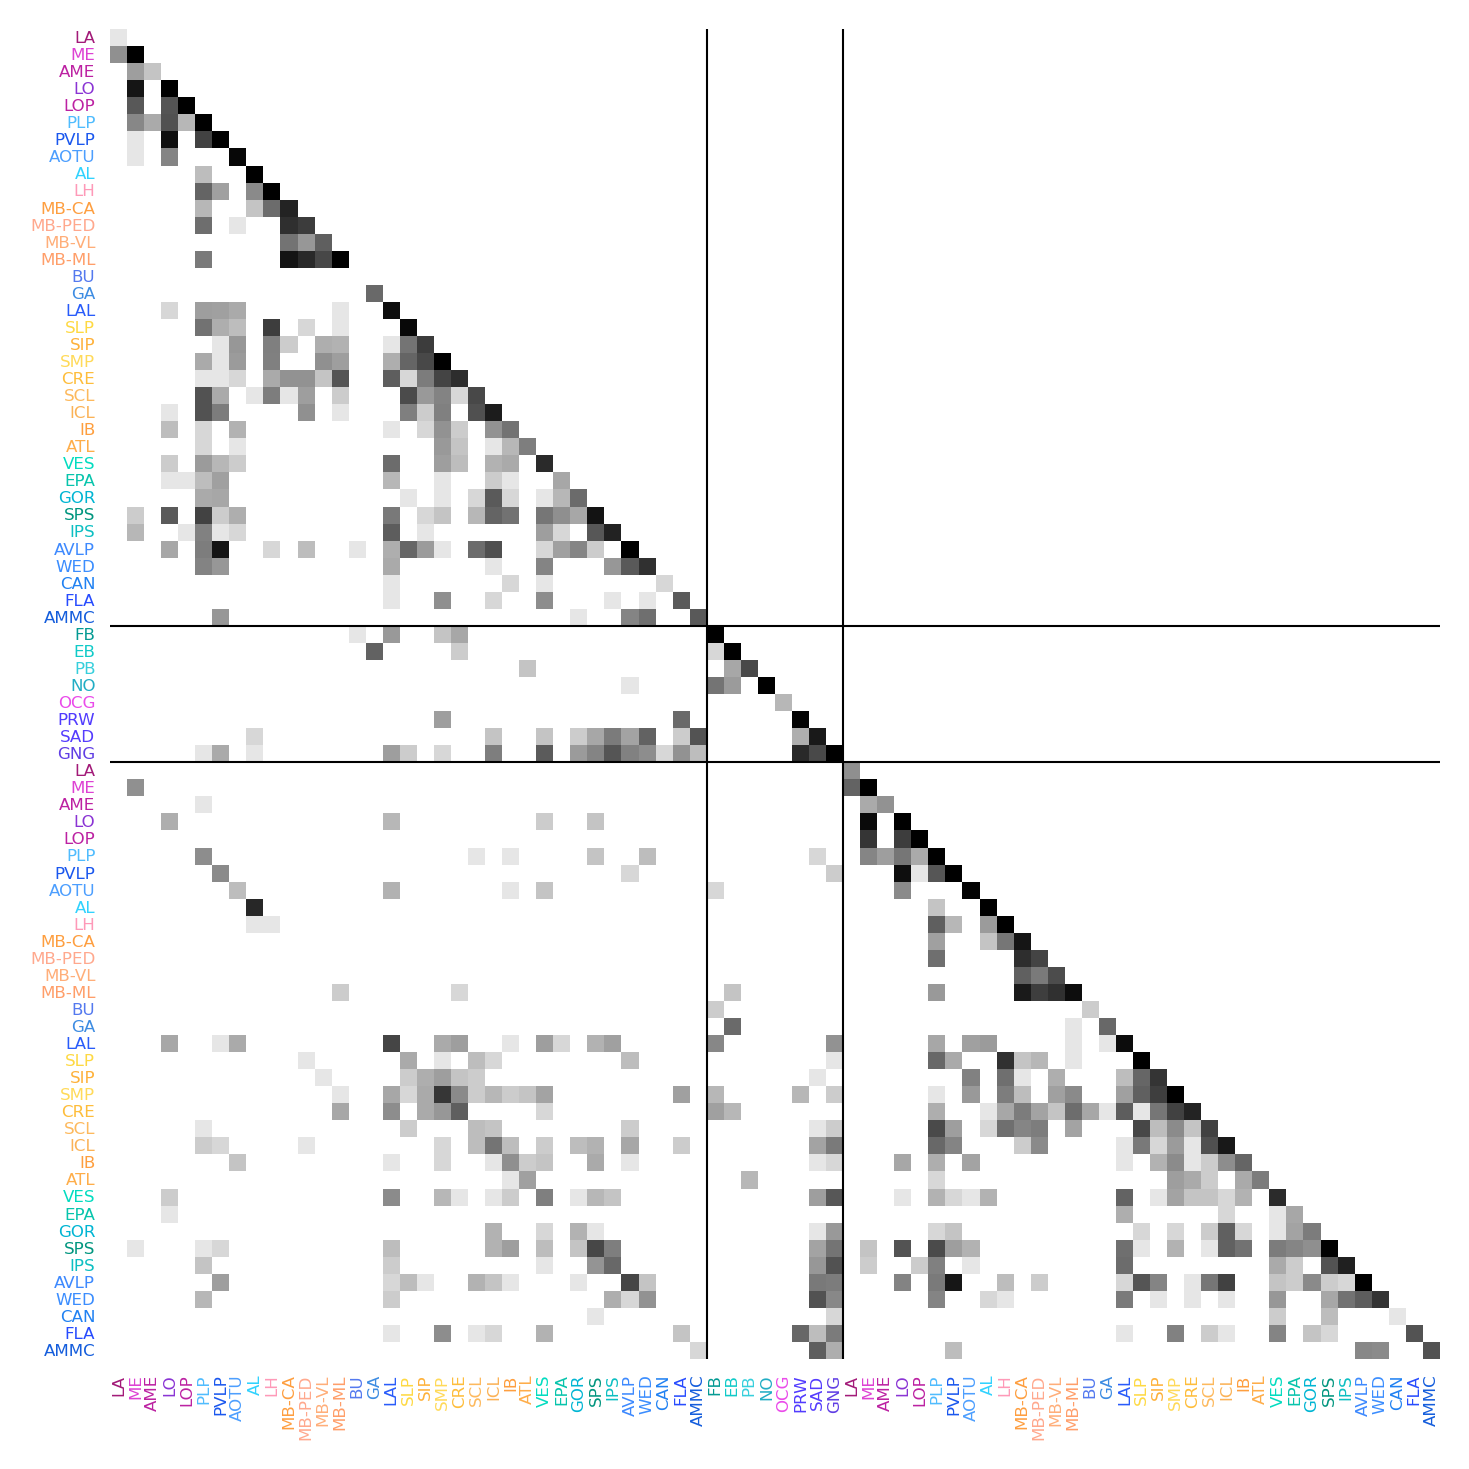

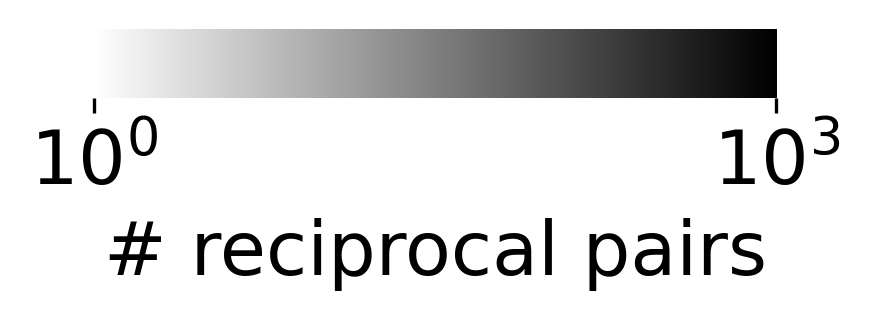

In [16]:
#upper triangle projectome, ran with 10^4 limit
n = len(neuropils)
reciprocal_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i+1):
        if i != j:
            reciprocal_matrix[i][j] = reciprocal_raw_matrix[i][j] + reciprocal_raw_matrix[j][i]
        else:
            reciprocal_matrix[i][j] = reciprocal_raw_matrix[i][j]
        
#(will have to sum opposites)
        
print(reciprocal_matrix)

nt_reciprocal_heatmap(reciprocal_matrix,
                  nt_colormap('all'),
                    out_path=f"{analysis_dir}/reciprocal_projectome_all.png"
                 )

In [65]:
%%time
#compare different kinds of neurotransmitter pairs--we might want to distinguish direction and build a full matrix
# ach-gaba

# count number of connections between neuropil pairs 

n = len(neuropils)
ach_gaba_raw_matrix = np.zeros((n, n))
gaba_ach_raw_matrix = np.zeros((n, n))

for i in range(n):
    np_i = neuropils[i]
    for j in range(n):
        np_j = neuropils[j]
        ach_gaba_raw_matrix[i][j] = len(reciprocal_df[
            (reciprocal_df["n1_nt"] == "ach") & (reciprocal_df["n2_nt"] == "gaba") &
            (reciprocal_df["np_1to2"] == np_i) & (reciprocal_df["np_2to1"] == np_j)])
        gaba_ach_raw_matrix[i][j] = len(reciprocal_df[
            (reciprocal_df["n1_nt"] == "gaba") & (reciprocal_df["n2_nt"] == "ach") &
            (reciprocal_df["np_1to2"] == np_i) & (reciprocal_df["np_2to1"] == np_j)])

        
#(will have to sum opposites)
        
print(ach_gaba_raw_matrix)

[[0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [3.000e+00 8.926e+03 1.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 9.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 3.500e+01]]
CPU times: user 6min 52s, sys: 458 ms, total: 6min 52s
Wall time: 6min 56s


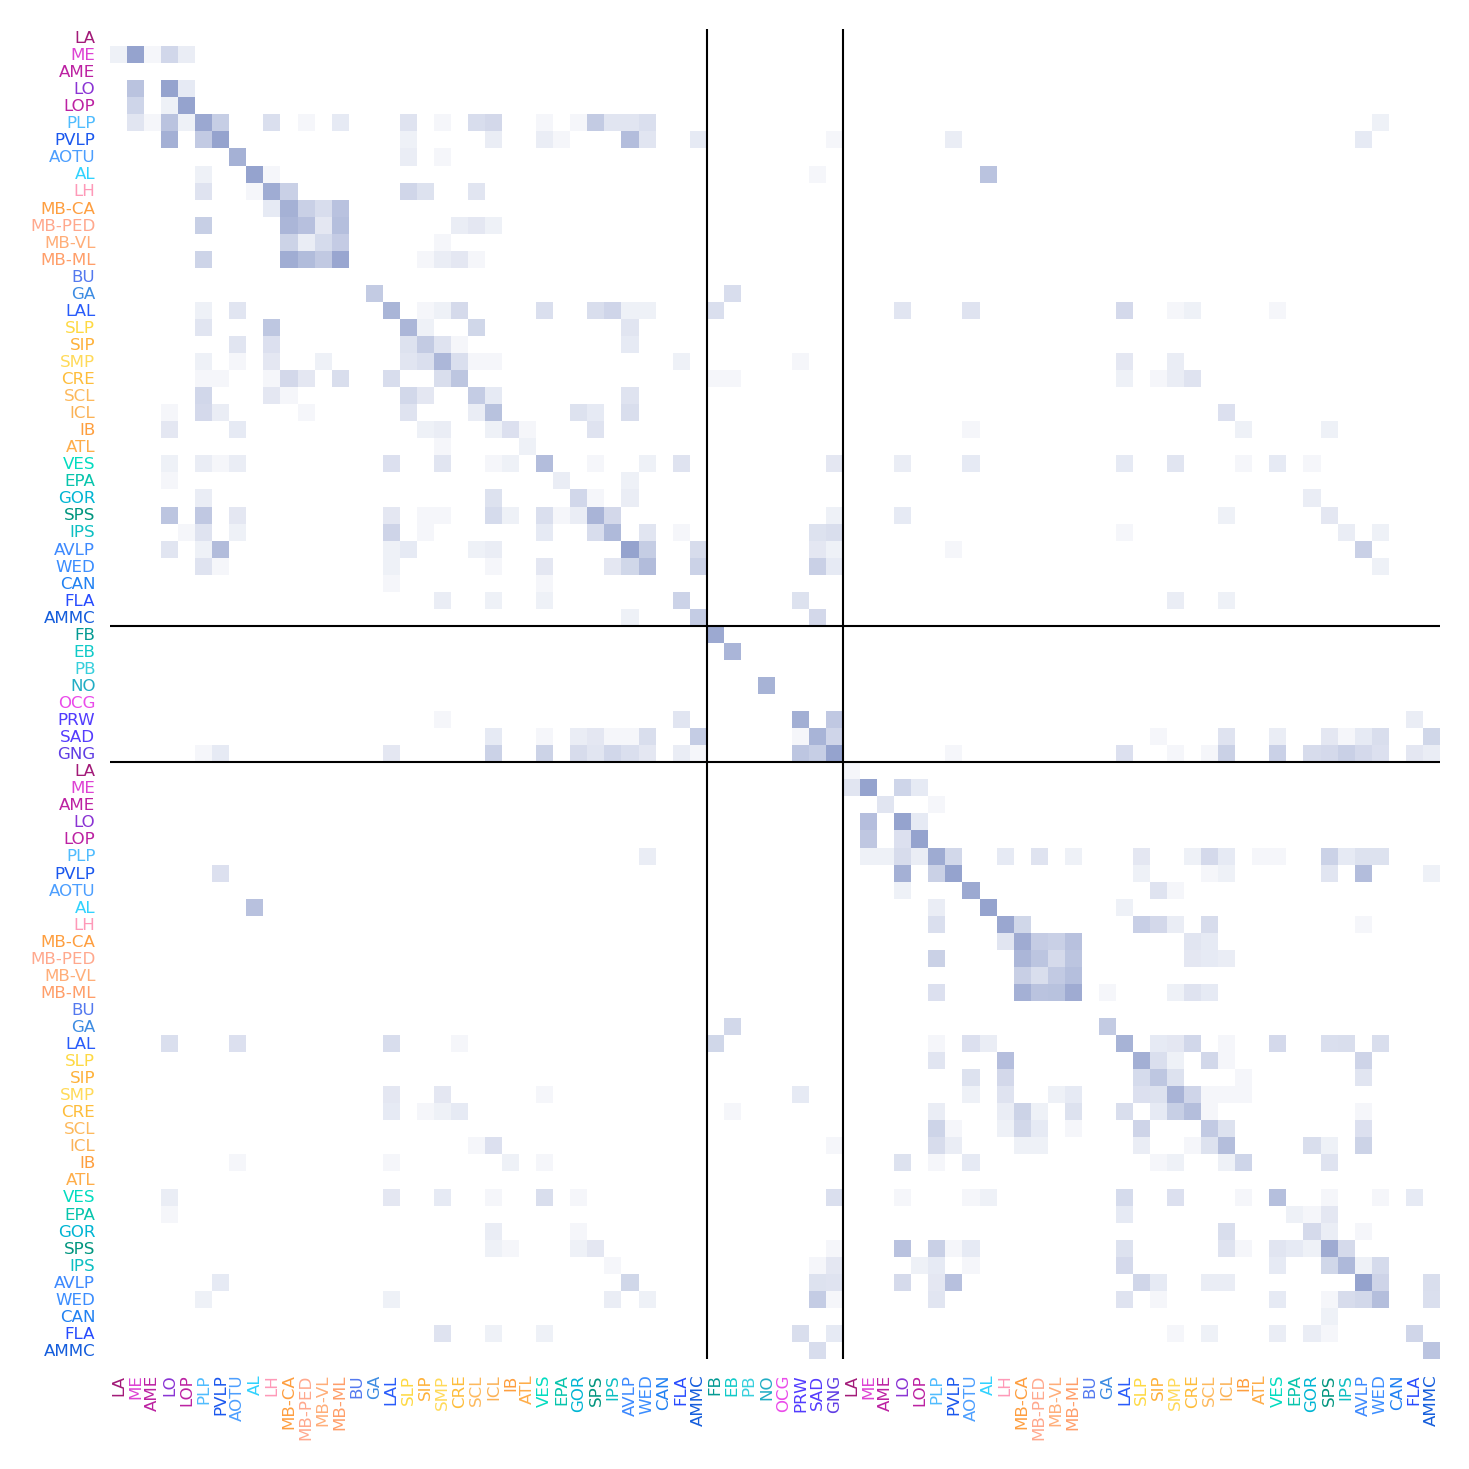

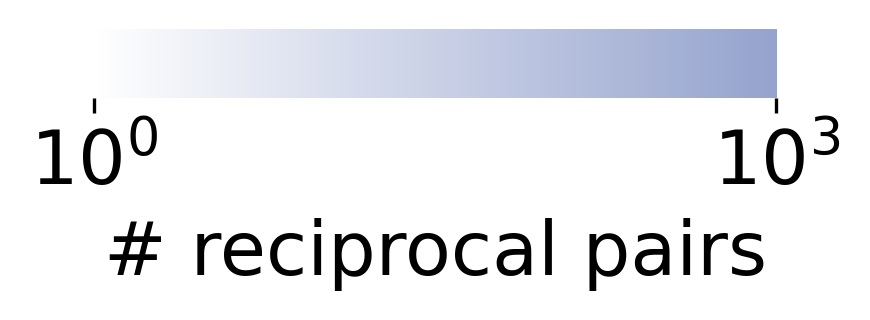

In [71]:
# np where ach connection was is on x, np where gaba connection is on y
ach_gaba_matrix = ach_gaba_raw_matrix + gaba_ach_raw_matrix.transpose()

nt_reciprocal_heatmap(ach_gaba_matrix,
                  nt_colormap('ach'),
                    out_path=f"{analysis_dir}/reciprocal_projectome_ach_gaba.png"
                 )

In [18]:
diagonal_sum = np.trace(reciprocal_matrix)

In [20]:
ratio = (len(reciprocal_df)-diagonal_sum)/len(reciprocal_df)
print(ratio)

0.12119536059380859
